# Dealing with non-PDF functions

So far, we've dealt with statistical functions, that have intrinsic PDF property, such that,

$$
\int f(x)\,\text{d}x = 1
$$

But ``pyMultiFit`` can also work with other functions that require fitting.
In this tutorial we'll see one such example in which we'll create custom function and their respective fitters.

## Gamma-ray Burst

Gamma-ray Burst (GRB) is an extremely energetic phenomena. 
It's study helps us gain better understanding about physics and extreme conditions.
A singular GRB can emit energies up to $10^{53}\,\text{erg}$ within a span of less than few seconds, which is more than our Sun would emit in its entire lifetime.

We will not discuss in depth about GRBs here, however, the data obtained from GRBs often follows some phenomenological models, such as,

1. Power-law,
$$
f(E) = A\left(\dfrac{E}{E_\text{pivot}}\right)^\alpha
$$
2. Comptonized power-law,
$$
f(E) = A\left(\dfrac{-E(2 + \lambda)}{E_\text{peak}}\right)\left(\dfrac{E}{E_\text{piv}}\right)^\lambda
$$
3. Band GRB model,
$$
\begin{equation}
f(E) = A\begin{cases}
\left(\dfrac{E}{E_\text{piv}}\right)^\alpha\exp\left(-\dfrac{E(2+\alpha)}{E_\text{peak}}\right) & E < \dfrac{(\alpha - \beta)E_\text{peak}}{2+\alpha}\\
\left[\dfrac{(\alpha-\beta)E_\text{peak}}{(2+\alpha)E_\text{piv}}\right]^{\alpha-\beta}\exp(\beta-\alpha)\left(\dfrac{E}{E_\text{piv}}\right)^\beta & E \geq \dfrac{(\alpha - \beta)E_\text{peak}}{2+\alpha}
\end{cases}
\end{equation}
$$
4. Smoothly-broken power-law, and
$$
\begin{gather}
m = \dfrac{\lambda_h - \lambda_l}{2}\quad;\quad b = \dfrac{\lambda_h + \lambda_l}{2}\\
\alpha_\text{piv} = \dfrac{\log_{10}(E_\text{piv}/E_b)}{\Delta}\quad ; \quad \beta_\text{piv} = m\Delta\log_e\dfrac{\exp(\alpha_\text{piv}) + \exp(-\alpha_\text{piv})}{2}\\
\alpha = \dfrac{\log_{10}(E/E_b)}{\Delta}\quad ; \quad \beta = m\Delta\log_e\dfrac{\exp(\alpha) + \exp(-\alpha)}{2}\\
f(E) = A\left(\dfrac{E}{E_\text{piv}}\right)^\beta10^{\beta-\beta_\text{piv}}
\end{gather}
$$
5. Black body model.
$$
f(E) = A\dfrac{E^2}{\exp(E/kT) - 1}
$$

where $E_\text{piv} = 100\,\text{keV}$, and combinations thereof.
Here, we'll try to use the `BaseFitter` class and `multiple_models` function in ``pyMultiFit` library to simulate and fit synthetic GRB data.

## PL + BB model

### Data preparation

Let's say we have a GRB spectrum that can be fitted with a power-law + black body model (PL + BB) model, with the following parameters.
To generate the data, we first create the PL and BB functions,

In [1]:
from typing import Tuple, Any

import matplotlib.pyplot as plt
import numpy as np


def power_law(x: np.ndarray, amplitude: float, alpha: float) -> np.ndarray:
    return amplitude * (x / 100.)**alpha


def black_body(x: np.ndarray, amplitude: float, kt: float) -> np.ndarray:
    num_ = x**2
    den_ = np.exp(x / kt) - 1
    return amplitude * (num_ / den_)

In order to generate the data, we can either add the two obtained values together, or use the `multiple_models` function from the `pyMultiFit` **generators** module,

In [2]:
# the energy of GRBs goes from 10 keV to 10^7 keV
x_val = np.logspace(1, 7, 10_000)

PL = [2.487e-2, -1.784]
BB = [1.553e-3, 56.645]

# initialize y as zeros_like
y_simple = np.zeros_like(x_val, dtype=float)

# add the powerlaw component to the y-array
y_simple += power_law(x_val, *PL)
# add the black body component to the y-array
y_simple += black_body(x_val, *BB)

/tmp/ipykernel_77678/1944169235.py:13: RuntimeWarning: overflow encountered in exp
  den_ = np.exp(x / kt) - 1


Let's plot the GRB model.

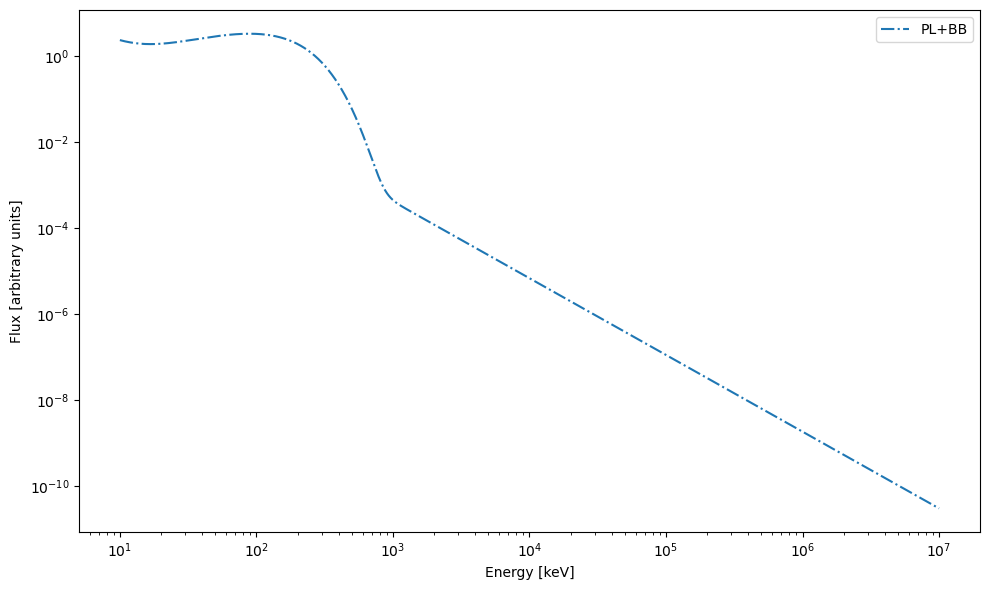

In [3]:
plt.figure(figsize=(10, 6))

plt.plot(x_val, y_simple, '-.', label='PL+BB')

plt.xlabel('Energy [keV]')
plt.ylabel('Flux [arbitrary units]')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The same can also be done by using dictionary mapping and `multiple_models` from **generators**

In [4]:
from pymultifit.generators import multiple_models

function_map = {'PL': power_law,
                'BB': black_body}

multifit_y = multiple_models(x=x_val, params=[PL, BB], model_list=['PL', 'BB'], mapping_dict=function_map)

/tmp/ipykernel_77678/1944169235.py:13: RuntimeWarning: overflow encountered in exp
  den_ = np.exp(x / kt) - 1


Let's break down what's happening here, `multiple_models` takes the following arguments,

1. `x`: The x-array of values
2. `params`: The parameters for each model. The parameters must follow the number of parameters per model.
3. `model_list`: The list of models to use for data generation, this must have the same number of values as the tuples in the `params` argument.
4. `mapping_dict`: A mapping of the model string (used in `model_list`) to the function or class that contains the definition of the model.

Additionally, other parameters include,

1. `noise_level`: The standard deviation of the noise to add to the data, if any.
2. `normalize`: Whether to normalize the distribution PDF or not.

In this case, since the models are non-statistical thus we don't need to use `normalize` keyword here.

The main reason to define a `function_map` is so that the models can also be used multiple times if required.
The `multiple_models` function handles the dictionary logic internally such that the `model_list` refers back to the `function_map` and updated the function values.

For example, with the `function_map` we are generating data for `['PL', 'BB']`, but the same map can also be used to generate `['PL', 'BB', 'PL']`. 

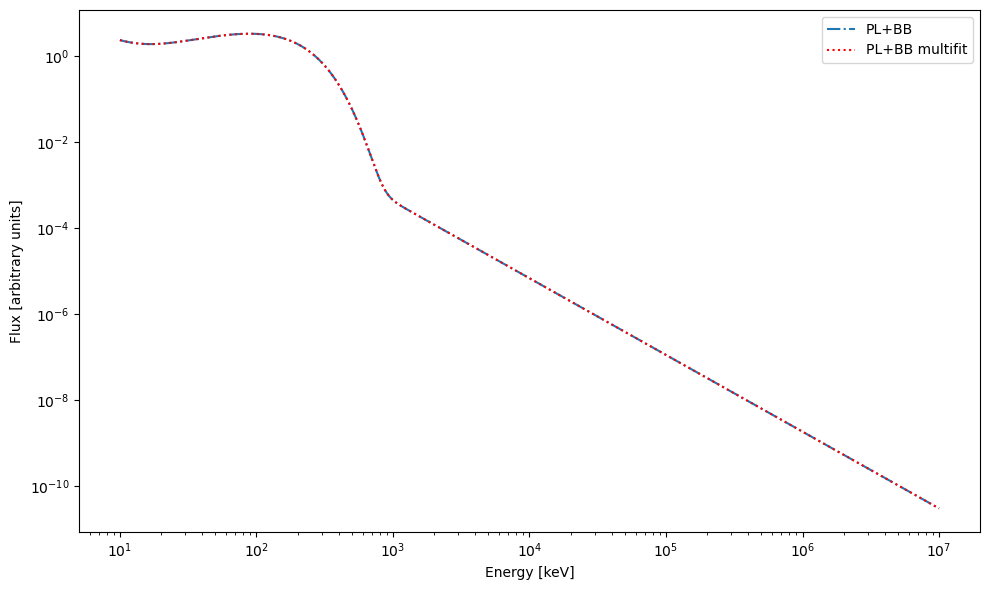

In [5]:
plt.figure(figsize=(10, 6))

plt.plot(x_val, y_simple, '-.', label='PL+BB')
plt.plot(x_val, multifit_y, 'r:', label='PL+BB multifit')

plt.xlabel('Energy [keV]')
plt.ylabel('Flux [arbitrary units]')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [6]:
print(np.allclose(y_simple, multifit_y))

True


So we're good to go here with both methods of data generation.

Next, it's time to fit the data, for that we can define custom fitters for both these models using `baseFitter` parent class.

### Data fitting

In order to fit the data, we make use of `MixedDataFitter` class which is capable of taking a `fitter_dictionary` just like `multiple_models` that dictate what models to mix for the fitting purposes.
For this we make the two fitter classes via `BaseFitter` template class, one for PL model and one for BB model.
These classes will be used by the `MixedDataFitter` to fit the data.

In [7]:
from pymultifit.fitters.backend import BaseFitter


class PowerLawFitter(BaseFitter):

    def __init__(self, x_values, y_values, max_iterations: int = 1000):
        super().__init__(x_values, y_values, max_iterations)
        self.n_par = 2

    @staticmethod
    def fitter(x: np.ndarray, params: Tuple[float, Any]):
        return power_law(x, *params)


class BlackBodyFitter(BaseFitter):

    def __init__(self, x_values, y_values, max_iterations: int = 1000):
        super().__init__(x_values, y_values, max_iterations)
        self.n_par = 2

    @staticmethod
    def fitter(x: np.ndarray, params: Tuple[float, Any]):
        return black_body(x, *params)


fitter_mapping = {'PowerLaw': PowerLawFitter,
                  'BlackBody': BlackBodyFitter}

In [8]:
from pymultifit.fitters import MixedDataFitter

mxf = MixedDataFitter(x_val, multifit_y, ['PowerLaw', 'BlackBody'], fitter_dictionary=fitter_mapping)

As discussed in [basic 4](https://pymultifit.readthedocs.io/latest/basic_examples/basics4.html), here, the `fitter_dictionary` will override the internal mapping and thus the fitter now will only have access to the two methods defined in the mapping provided by the user.

Now let's fit the data and plot it.

/tmp/ipykernel_77678/1944169235.py:13: RuntimeWarning: overflow encountered in exp
  den_ = np.exp(x / kt) - 1
/tmp/ipykernel_77678/1944169235.py:8: RuntimeWarning: overflow encountered in power
  return amplitude * (x / 100.)**alpha


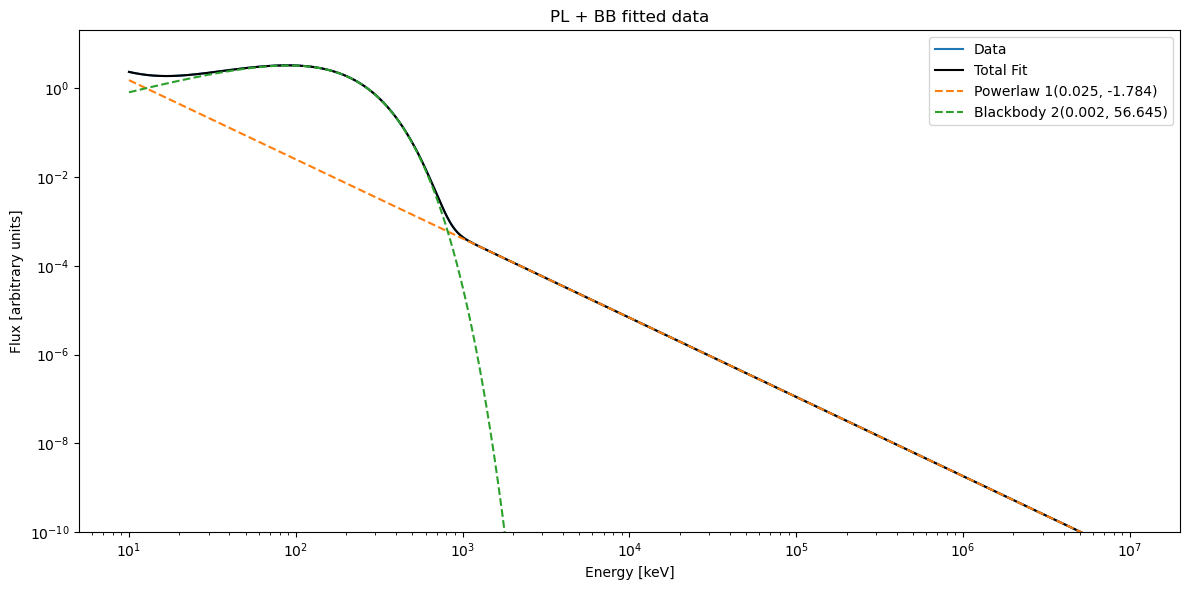

In [9]:
guesses = [(1e-3, -2), (1e-3, 10)]

mxf.fit(p0=guesses)
mxf.plot_fit(show_individuals=True, x_label='Energy [keV]', y_label='Flux [arbitrary units]',
             title='PL + BB fitted data')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_ylim(bottom=1e-10, top=20)
plt.tight_layout()

Let's get the parameters and their error estimates,

In [10]:
mxf.get_model_parameters(model='PowerLaw', errors=True)

{'parameters': [array([ 0.02487, -1.784  ])],
 'errors': [array([7.23408465e-19, 1.35840399e-17])]}

In [11]:
mxf.get_model_parameters(model='BlackBody', errors=True)

{'parameters': [array([1.5530e-03, 5.6645e+01])],
 'errors': [array([3.13273473e-21, 4.42631733e-17])]}

Note that the model names used to get the values are the same as defined in the `fitter_mapping` parameter.
Of course, such negligible errors are to be expected since we didn't include any noise in the data.

This concludes the second exploration tutorial, thus `pyMultiFit` can not only be used with just statistical models, but also with other **fitting** functions.